In [1]:
import sys
sys.path.insert(0, "/ut3/muscat/src/AFPy")
import LC_funcs as lc

In [2]:
import numpy as np
# import LC_funcs as lc
import matplotlib.pyplot as plt
from astropy.table import Table

import math
from scipy.optimize import minimize
import emcee
import corner
from multiprocessing import Pool

from pytransit import QuadraticModel
from ldtk import LDPSetCreator, BoxcarFilter

import os
os.environ['OMP_NUM_THREADS']='1'
os.nice(19)

19

In [3]:
## Setting parameters

inst='muscat3'
bands = ['g','r','i','z']
nband = len(bands)

## Please change the following parameters
toi='5671'           # TOI number
plnum='01'               # ID number of the candidate in the system

date='220630'            # date for file names
date4plot='2022-Jun-30 UT'  # date to be shown in the plots

In [4]:
from urllib.request import urlopen
import json

url = f"https://exofop.ipac.caltech.edu/tess/target.php?id=TOI-{toi}&json"
response = urlopen(url)
data_json = json.loads(response.read())
# data_json['coordinates']
ra  = float(data_json['coordinates']['ra'])      # target coord in deg
dec = float(data_json['coordinates']['dec'])       # target coord in deg
ra, dec 

(211.009219627329, 38.6183309836516)

In [5]:
tic = data_json['basic_info']['tic_id']

In [6]:
## Loading photometry files

INST = {'muscat': 'MuSCAT',
        'muscat2': 'MuSCAT2',
        'muscat3': 'MuSCAT3'}
initial = 'jd'

phot = []
for i in range(nband):
#    photfile = tic + '-' + plnum + '_20' + date + '_' + inst + '_' + bands[i] + '_measurements.csv'
    photfile = 'TOI{0}.{1}L-{2}20{3}_{4}_{5}_measurements.csv'.format(toi, plnum, initial, date, INST[inst], bands[i])
    phot.append(Table.read(photfile))

In [7]:
len(phot), len(phot[0])

(4, 120)

In [8]:
global x, y, ye, amass, ttr
x=[]
y=[]
ye=[]
amass=[]

for i in range(nband):
    x.append(phot[i]['BJD_TDB']-2450000.)
    y.append(phot[i]['Flux'])
    ye.append(phot[i]['Err'])
    amass.append(phot[i]['Airmass'])

ttr=[]
for i in range(nband):
    ttr.append(QuadraticModel())
    ttr[i].set_data(x[i])

In [9]:
phot[0].info

<Table length=120>
   name    dtype 
--------- -------
  BJD_TDB float64
     Flux float64
      Err float64
  Airmass float64
  DX(pix) float64
  DY(pix) float64
FWHM(pix) float64
Peak(ADU)   int64

In [10]:
data_json['stellar_parameters'][1]

{'tel': '',
 'inst': '',
 'teff': '3380',
 'teff_e': '157',
 'logg': '4.81894',
 'logg_e': '0.00440884',
 'srad': '0.408427',
 'srad_e': '0.0125522',
 'logr': '',
 'logr_e': '',
 'sindex': '',
 'sindex_e': '',
 'halpha': '',
 'halpha_e': '',
 'vsini': '',
 'vsini_e': '',
 'rotper': '',
 'rotper_e': '',
 'met': None,
 'met_e': None,
 'mass': '0.400962',
 'mass_e': '0.0205648',
 'dens': 8.298104,
 'dens_e': 0.339476,
 'lum': '0.0196151',
 'lum_e': '0.00487705',
 'otime': '',
 'otime_e': '',
 'rv': '',
 'rv_e': '',
 'dist': '167.245',
 'dist_e': '1.488',
 'age': '',
 'age_e': '',
 'snr': '',
 'snr_e': '',
 'fitq': '',
 'snotes': 'TIC v8.2',
 'sdate': '2019-04-15',
 'suser': 'TESS project',
 'sgroup': '',
 'stag': ''}

In [11]:
star_params = data_json['stellar_parameters'][1]
teff,teff_err = float(star_params['teff']), float(star_params['teff_e'])
logg, logg_err = float(star_params['logg']), float(star_params['logg_e'])
# feh, feh_err = float(star_params['met']), float(star_params['met_e'])
feh, feh_err = 0, 0.1

print(f"{teff}+/-{teff_err}, {logg}+/-{logg_err}, {feh}+/-{feh_err}")

3380.0+/-157.0, 4.81894+/-0.00440884, 0+/-0.1


In [12]:
%%time

## LDTK ##

### Filter setting for MuSCAT; Don't change.
filters = [BoxcarFilter('g', 430, 540),  # Define your passbands
           BoxcarFilter('r', 560, 700),  # - Boxcar filters useful in
           BoxcarFilter('i', 560, 700),
           BoxcarFilter('z', 830, 910)]  #   transmission spectroscopy

## Please change the value and error of stellar Teff, loog, and z (metallicity)
sc = LDPSetCreator(teff=(teff, teff_err),    # Define your star, and the code
                   logg=(logg, logg_err),    # downloads the uncached stellar
                      z=(feh, feh_err),    # spectra from the Husser et al.
                     filters=filters)    # FTP server automatically.


ps = sc.create_profiles()                # Create the limb darkening profiles
cq,eq = ps.coeffs_qd(do_mc=True)         # Estimate quadratic law coefficients

qc,qe = ps.coeffs_qd()
ldc = []
for i in range(len(ps._filters)):
    print(ps._filters[i], qc[i][0], qc[i][1])
    ldc.append((qc[i][0], qc[i][1]))

print(ldc)

g 0.540763449035079 0.2950272751531887
r 0.5186704777883853 0.2622824096984694
i 0.5186704777883853 0.2622824096984694
z 0.2508153511255053 0.2940684521671961
[(0.540763449035079, 0.2950272751531887), (0.5186704777883853, 0.2622824096984694), (0.5186704777883853, 0.2622824096984694), (0.2508153511255053, 0.2940684521671961)]
CPU times: user 10.1 s, sys: 71 ms, total: 10.1 s
Wall time: 10.4 s


In [13]:
def calc_chi2_linear(p):
    
    d = (p[0], p[1], p[2], p[3])
    int_t0 = int(x[0][0])
    
    chi2 = 0.
    for i in range(nband):
        
        flux_time = d[i]*(x[i]-int_t0)
        c = np.polyfit(amass[i], y[i]-flux_time, 1)
        chi2 = chi2 + np.sum( (y[i] - np.polyval(c, amass[i]) + flux_time)**2 / ye[i] / ye[i] )
        
    return chi2

    
def calc_chi2_tr_achromatic(p):
    
    Tc = p[0]
    b = p[1]
    a_Rs = p[2]
    k = p[3]
    d = (p[4], p[5], p[6], p[7])

    
    if k < 0.01 or k > 0.25:
        return np.inf
        
    if b < 0:
        #return np.inf
        b = -1.0*b
    
    if b > 1.0:
        return np.inf
    
    if a_Rs <=0:
        return np.inf
    
    if b/a_Rs >= 1:
        return np.inf
    
    inc = math.acos(b/a_Rs)
    
    P = kwargs['P'] if 'P' in kwargs.keys() else 0
    e = kwargs['e'] if 'e' in kwargs.keys() else 0
    omega = kwargs['omega'] if 'omega' in kwargs.keys() else 0
    ldc = kwargs['ldc'] if 'ldc' in kwargs.keys() else [(0,0),(0,0),(0,0)]
    
    
    Tc0 = kwargs['Tc_pred'] if 'Tc_pred' in kwargs.keys() else 0.
    Tc0e = kwargs['Tc_pred_err'] if 'Tc_pred_err' in kwargs.keys() else 0.
    
    a_Rs0 = kwargs['a_Rs'] if 'a_Rs' in kwargs.keys() else 0.
    a_Rs0e = kwargs['a_Rs_err'] if 'a_Rs_err' in kwargs.keys() else 0.
    
    b0 = kwargs['b'] if 'b' in kwargs.keys() else 0.
    b0e = kwargs['b_err'] if 'b_err' in kwargs.keys() else 0.
    
    T140 = kwargs['T14'] if 'T14' in kwargs.keys() else 0.
    T140e = kwargs['T14_err'] if 'T14_err' in kwargs.keys() else 0.
    
    if Tc0 > 0. and abs(Tc - Tc0) > P/2.:
        return  np.inf    
    
    chi2 = 0.
    for i in range(nband):

        flux_tr = ttr[i].evaluate_ps(k, ldc[i], Tc, P, a_Rs, inc, e, omega)
        flux_tr_time = d[i]*(x[i]-Tc) * flux_tr
        c = np.polyfit(amass[i], (y[i]-flux_tr_time)/flux_tr, 1)
        chi2 = chi2 + np.sum( (y[i] - (np.polyval(c, amass[i])+d[i]*(x[i]-Tc)) * flux_tr)**2 / ye[i] / ye[i] )

    
    if Tc0 > 0. and  Tc0e > 0:
        chi2 = chi2 + ((Tc - Tc0)/Tc0e)**2
        
    if a_Rs0 > 0.:
        chi2 = chi2 + ((a_Rs - a_Rs0)/a_Rs0e)**2
    
    if b0 > 0.:
        chi2 = chi2 + ((b - b0)/b0e)**2
        
    if T140 > 0.:
        cosi = b / a_Rs
        sini = np.sqrt(1. - cosi**2)
        k_mean = np.mean(k)
        T14 = P/np.pi * math.asin(1./a_Rs*np.sqrt((1.+k_mean)**2 - b**2)/sini);
        chi2 = chi2 + (T14 - T140)**2/T140e**2
        
    return chi2


def ln_like_tr_achromatic(p):
    
    return -calc_chi2_tr_achromatic(p)

In [14]:
planet_params = data_json['planet_parameters'][1]
T0_TFOP, T0e_TFOP = float(planet_params['epoch']), float(planet_params['epoch_e'])
P_TFOP, Pe_TFOP = float(planet_params['per']), float(planet_params['per_e'])
T14_TFOP, T14e_TFOP = float(planet_params['dur'])/24, float(planet_params['dur_e'])/24
k_TFOP, ke_TFOP = np.sqrt(float(planet_params['dep_p'])/1e6), np.sqrt(float(planet_params['dep_p_e'])/1e6)
print(f"T0={T0_TFOP}+/-{T0e_TFOP}\nP={P_TFOP}+/-{Pe_TFOP}\nk={k_TFOP:.2f}+/-{ke_TFOP:.2f}")

T0=2459685.753346+/-0.0018235
P=3.3079817+/-0.0006559
k=0.28+/-0.01


In [15]:
Ms_TFOP, Mse_TFOP = float(star_params['mass']), float(star_params['mass_e'])
Rs_TFOP, Rse_TFOP = float(star_params['srad']), float(star_params['srad_e'])
print(f"{Rs_TFOP}+/-{Rse_TFOP}, {Ms_TFOP}+/-{Mse_TFOP}")

0.408427+/-0.0125522, 0.400962+/-0.0205648


In [16]:
## Please change the following values
b_TFOP = 0
###########

## No need to change ##
rhos = Ms_TFOP/Rs_TFOP**3 # stellar deinsity in rho_sun
rhose = np.sqrt( (1/Rs_TFOP**3)**2 * Mse_TFOP**2\
                            + (3*Ms_TFOP/Rs_TFOP**4)**2 * Rse_TFOP**2 )
a_Rs_TFOP = (rhos/0.01342*P_TFOP**2)**(1/3)
a_Rse_TFOP = 1/3*(1/0.01342*P_TFOP**2)**(1/3) * rhos**(-2/3) * rhose
print('a_Rs_TFOP = {0:.2f} +/- {1:.2f}'.format(a_Rs_TFOP, a_Rse_TFOP))
#####################


epoch = int((np.median(phot[0]['BJD_TDB']) - T0_TFOP + 0.3)/P_TFOP)
Tc_TFOP = T0_TFOP + P_TFOP * epoch
Tce_TFOP = np.sqrt(T0e_TFOP**2 + (Pe_TFOP*epoch)**2)
print('Tc_TFOP = {0:.5f} +/- {1:.5f}'.format(Tc_TFOP, Tce_TFOP))

global kwargs

kwargs = {
    'P': P_TFOP,
    'e': 0,
    'omega': 0,
    'ldc': ldc,
    'a_Rs': a_Rs_TFOP,
    'a_Rs_err': a_Rse_TFOP,
    'Tc_pred': Tc_TFOP - 2450000,
    ## optional, comment out if not used ###
    'T14': T14_TFOP,
    'T14_err': T14e_TFOP,
    'Tc_pred_err': Tce_TFOP,
    ###########
}

a_Rs_TFOP = 16.87 +/- 0.59
Tc_TFOP = 2459761.83693 +/- 0.01520


In [17]:
%%time
## minimize for linear function
p0 = (0, 0, 0, 0)
res_lin = minimize(calc_chi2_linear, p0, method='Nelder-Mead')
print(res_lin.fun, res_lin.success, res_lin.x)
res_lin = minimize(calc_chi2_linear, res_lin.x, method='Nelder-Mead')
print(res_lin.fun, res_lin.success, res_lin.x)


ndata = len(x[0])+len(x[1])+len(x[2])
npar_lin = len(res_lin.x)+3
print('npar(linear) = ', npar_lin)
bic_lin = res_lin.fun + npar_lin * np.log(ndata)
print('BIC(linear) = ', bic_lin)

39720.560248204776 True [0.00114672 0.00088526 0.00083054 0.00098305]
39720.560248204776 True [0.00114672 0.00088526 0.00083054 0.00098305]
npar(linear) =  7
BIC(linear) =  39766.91008776712
CPU times: user 242 ms, sys: 47 µs, total: 242 ms
Wall time: 239 ms


In [18]:
%%time
## minimize for transit+baseline model

OFFSET = -0.005
Tc0 = Tc_TFOP - 2450000. + OFFSET
k0 = k_TFOP
a_Rs0 = a_Rs_TFOP
b0 = b_TFOP
d00, d10, d20, d30 = 0, 0, 0, 0
p0 = np.array( (Tc0, b0, a_Rs0, k0, d00, d10, d20, d30) )

result = minimize(calc_chi2_tr_achromatic, p0, method='Nelder-Mead')
print(result.fun, result.success, result.x)

inf False [9.76183193e+03 0.00000000e+00 1.68672593e+01 2.84921042e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
CPU times: user 17.2 ms, sys: 29 µs, total: 17.2 ms
Wall time: 15.3 ms


In [19]:
%%time
## minimize again if needed
result = minimize(calc_chi2_tr_achromatic, result.x, method='Nelder-Mead')
print(result.fun, result.x)

inf [9.76183193e+03 0.00000000e+00 1.68672593e+01 2.84921042e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
CPU times: user 13.3 ms, sys: 4.04 ms, total: 17.3 ms
Wall time: 15.5 ms


ccd= 0


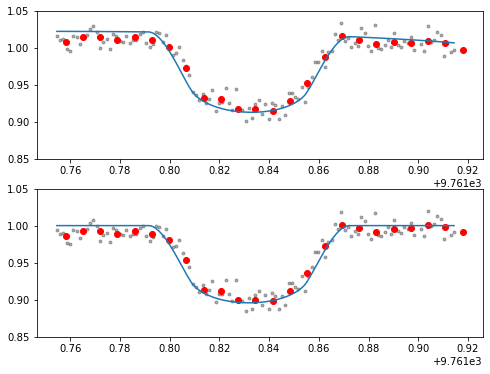

ccd= 1


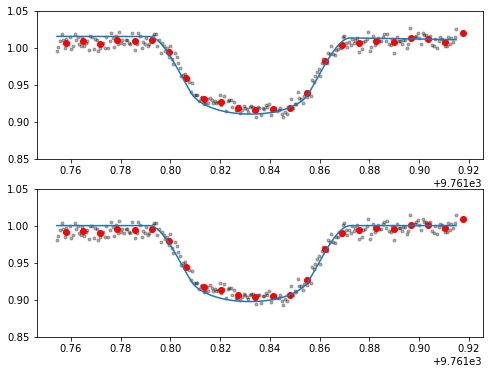

ccd= 2


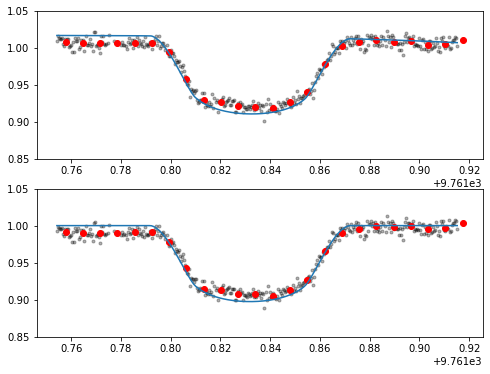

ccd= 3


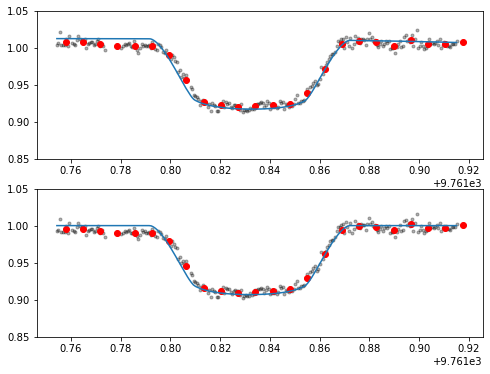

In [20]:
d = [0, 0, 0, 0]
Tc, b, a_Rs, k, d[0], d[1], d[2], d[3] = result.x

P = kwargs['P']
e = kwargs['e']
omega = kwargs['omega']
inc = math.acos(b/a_Rs)

binsize=600/86400

ymin=0.85
ymax=1.05

for i in range(nband):
    print('ccd=',i)

    flux_tr = ttr[i].evaluate_ps(k, ldc[i], Tc, P, a_Rs, inc, e, omega)
    xmodel = np.linspace(np.min(x[i]), np.max(x[i]), 200)
    ttr_model = QuadraticModel()
    ttr_model.set_data(xmodel)
    ymodel = ttr_model.evaluate_ps(k, ldc[i], Tc, P, a_Rs, inc, e, omega)

#    c0, c1 = lc.weighted_linfit(amass[i], y[i]/flux_tr, ye[i]/flux_tr)
    flux_tr_time = d[i]*(x[i]-Tc) * flux_tr
    c = np.polyfit(amass[i], (y[i]-flux_tr_time)/flux_tr, 1)
    t0 = np.min(x[i])
    
    tbin, ybin, yebin=\
        lc.binning_equal_interval(x[i], y[i], ye[i], binsize, t0)

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(x[i],y[i],'.k',alpha=0.3)
    ax[0].plot(tbin, ybin,'or')
    ax[0].plot(x[i], flux_tr * (np.polyval(c, amass[i]) + d[i]*(x[i]-Tc)))
    ax[0].set_ylim(ymin, ymax)
    
    tbin, ybin, yebin=\
        lc.binning_equal_interval(x[i], y[i]/(np.polyval(c, amass[i]) + d[i]*(x[i]-Tc)), ye[i], binsize, t0)
    ax[1].plot(x[i],y[i]/(np.polyval(c, amass[i]) + d[i]*(x[i]-Tc)),'.k',alpha=0.3)
    ax[1].plot(tbin, ybin,'or')
    ax[1].plot(xmodel, ymodel)
    ax[1].set_ylim(ymin, ymax)

    plt.show()

In [21]:
%%time

ndim, nwalkers = 8, 50
nsteps = 10000
pos = [result.x + 1e-5*np.random.randn(ndim) for i in range(nwalkers)]
#sampler.reset()

with Pool(12) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_like_tr_achromatic, pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 10000/10000 [00:38<00:00, 257.30it/s]


CPU times: user 37.2 s, sys: 5.1 s, total: 42.3 s
Wall time: 39.1 s


In [22]:
log_prob = sampler.get_log_prob()
argmax = np.argmax(log_prob)
j=int(argmax/nwalkers)
i=argmax-nwalkers*j
chain_best = sampler.flatchain[argmax]
chi2_best = -log_prob[j,i]
print(chi2_best)
npar_tr = len(chain_best)+3
print('ndata = ', ndata)
print('npar(transit+linear) = ', npar_tr)
bic_tr = chi2_best + npar_tr * np.log(ndata)
print('BIC(transit+linear) = ', bic_tr)

delta_bic = bic_lin - bic_tr
print('delta_BIC = ', delta_bic)

inf
ndata =  751
npar(transit+linear) =  11
BIC(transit+linear) =  inf
delta_BIC =  -inf


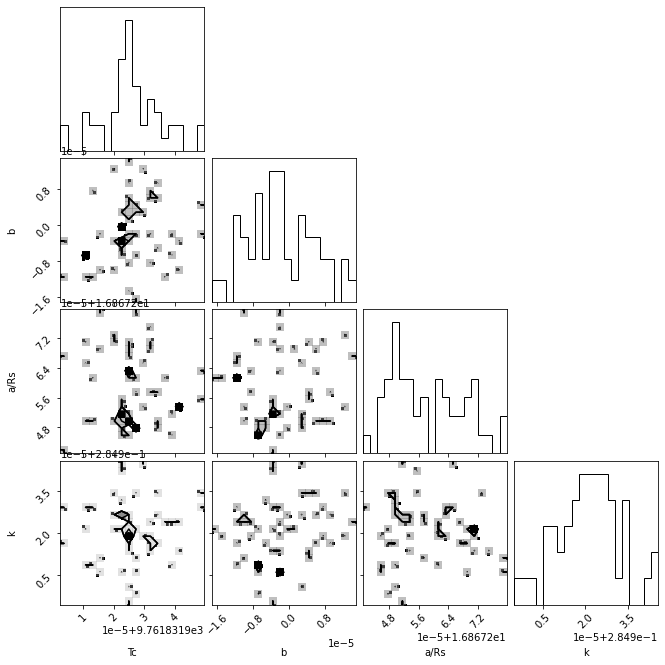

In [23]:
n0=5000
samples = sampler.get_chain(flat=True, discard=n0, thin=10)

fig = corner.corner(samples[:,0:4], labels=['Tc', 'b', 'a/Rs', 'k'])

In [24]:
val = lc.percentile(samples[:,0])
print('Tc = {0:.5f} +{1:.5f} -{2:.5f}'.format(val[0],val[2]-val[0],val[0]-val[1]))
Tc_med, Tc_1h, Tc_1m = val[0], val[2]-val[0],val[0]-val[1]
val = lc.percentile(samples[:,3])
print('Rp/Rs = {0:.4f} +{1:.4f} -{2:.4f}'.format(val[0],val[2]-val[0],val[0]-val[1]))

Tc = 9761.83193 +0.00001 -0.00001
Rp/Rs = 0.2849 +0.0000 -0.0000


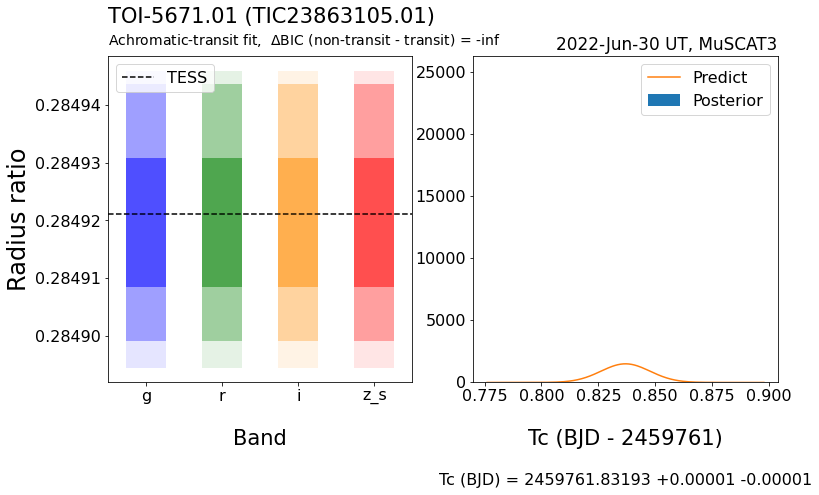

In [25]:
## make plots for Rp/Rs and Tc

Tc_med = lc.percentile(samples[:,0])[0]
b_med = lc.percentile(samples[:,1])[0]
a_Rs_med = lc.percentile(samples[:,2])[0]
inc_med = math.acos(b_med/a_Rs_med) 
d_med = []
d_med.append(lc.percentile(samples[:,4])[0])
d_med.append(lc.percentile(samples[:,5])[0])
d_med.append(lc.percentile(samples[:,6])[0])
d_med.append(lc.percentile(samples[:,7])[0])

bands = np.array((0,1,2,3))
k_val = lc.percentile(samples[:,3])
k_med = k_val[0]
k_err = np.array((k_val[0]-k_val[1], k_val[2]-k_val[0]))
k_err2 = np.array((k_val[0]-k_val[3], k_val[4]-k_val[0]))
k_err3 = np.array((k_val[0]-k_val[5], k_val[6]-k_val[0]))

colors = ['blue','green','darkorange','red']

fig = plt.figure(figsize=(12,6))
fsize=16
plt.rcParams['font.size'] = fsize

ax0, ax1 = fig.subplots(1, 2)

ype1 = np.zeros((2,1))
ype2 = np.zeros((2,1))
ype3 = np.zeros((2,1))
ype1[0,0], ype1[1,0] = k_val[0]-k_val[1], k_val[2]-k_val[0]
ype2[0,0], ype2[1,0] = k_val[0]-k_val[3], k_val[4]-k_val[0]
ype3[0,0], ype3[1,0] = k_val[0]-k_val[5], k_val[6]-k_val[0]


for i in range(len(bands)):
    
    xp = (i)
    yp = (k_med)
    ax0.errorbar(xp, yp, yerr=ype1, elinewidth=40, fmt='none', alpha=0.5, zorder=1, color=colors[i])
    ax0.errorbar(xp, yp, yerr=ype2, elinewidth=40, fmt='none', alpha=0.3, zorder=2, color=colors[i])
    ax0.errorbar(xp, yp, yerr=ype3, elinewidth=40, fmt='none', alpha=0.1, zorder=3, color=colors[i])

#plt.errorbar(bands, k_mid[i], yerr=k_err1.T[i], elinewidth=40, fmt='none', alpha=0.5, zorder=1, color=colors[i])
#plt.errorbar(bands, k_mid, yerr=k_err2.T, elinewidth=40, fmt='none', alpha=0.3, zorder=2, color=colors[i])
#plt.errorbar(bands, k_mid, yerr=k_err3.T, elinewidth=40, fmt='none', alpha=0.1, zorder=3, color=colors[i])

ax0.axhline(k_TFOP, linestyle='dashed', color='black', label='TESS')

ax0.set_xlim(-0.5,3.5)
ax0.set_xticks([0,1,2,3])
ax0.set_xticklabels(['g','r','i','z_s'])
ax0.set_ylabel('Radius ratio', fontsize=fsize*1.5)
fsize=14
#ax0.set_title(toi+' ('+tic+')', loc='left', fontsize=fsize*1.5)
target_name = 'TOI-{0}.{1} (TIC{2}.{1})'.format(toi,plnum,tic)
ax0.text(0., 1.12, target_name, horizontalalignment='left',\
         verticalalignment='center', transform=ax0.transAxes, fontsize=fsize*1.5)
ax0.text(0., 1.05, 'Achromatic-transit fit,  $\Delta$BIC (non-transit - transit) = {0:.1f}'.format(delta_bic),\
         horizontalalignment='left', verticalalignment='center', transform=ax0.transAxes, fontsize=fsize)

ax1.set_title(date4plot+', MuSCAT3', loc='right', fontsize=fsize*1.2)
ax0.set_xlabel('Band', labelpad=25, fontsize=fsize*1.5)
ax0.legend(loc='upper left')


intt0 = int(np.min(samples[:,0]))
ax1.hist(samples[:,0]-intt0, bins=1, zorder=5, label='Posterior')

Tc_TFOP = T0_TFOP + P_TFOP * epoch - 2450000
xmodel = np.linspace(Tc_TFOP-4*Tce_TFOP, Tc_TFOP+4*Tce_TFOP, 200)
ymodel = 1500 * np.exp( -(xmodel-Tc_TFOP)**2 / Tce_TFOP**2)
ax1.plot(xmodel-intt0, ymodel, label='Predict')

Tc_text = 'Tc (BJD) = {0:.5f} +{1:.5f} -{2:.5f}'.format(2450000+Tc_med, Tc_1h, Tc_1m)
ax1.text(0.5, -0.3, Tc_text, horizontalalignment='center',\
         verticalalignment='center', transform=ax1.transAxes)

ax1.set_xlabel('Tc (BJD - 245{0})'.format(intt0), labelpad=25, fontsize=fsize*1.5)
ax1.legend()

#outfile = tic + '-' + plnum + '_20' + date + '_' + inst + '_grz_lcfit_achromatic.png'
outfile = 'TOI{0}.{1}L-{2}20{3}_{4}_griz_lcfit_achromatic.pdf'.format(toi, plnum, initial, date, INST[inst])
plt.savefig(outfile, bbox_inches='tight',pad_inches=0.1)
plt.show()

0 rms = 0.0124
1 rms = 0.0085
2 rms = 0.0087
3 rms = 0.0067


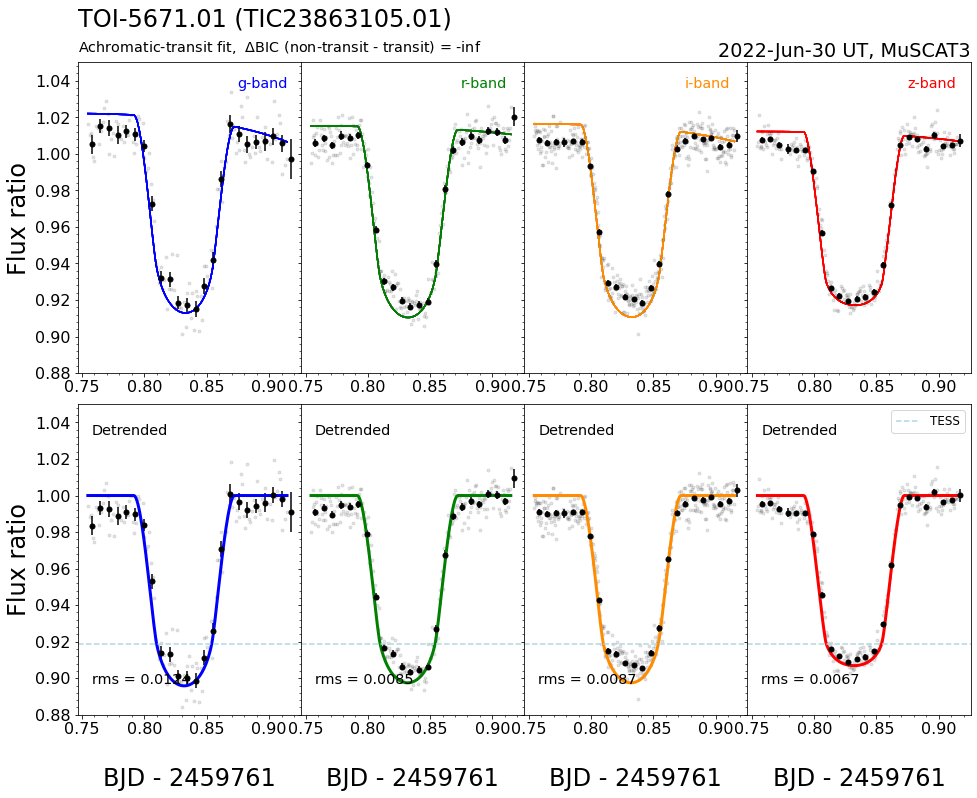

In [29]:
import math
from matplotlib.ticker import AutoMinorLocator

P=kwargs['P']
e=kwargs['e']
omega=kwargs['omega']

binsize = 600/86400.
ymin1 = 0.88
ymax1 = 1.05
ymin2 = 0.88
ymax2 = 1.05

bands = ['g-band', 'r-band', 'i-band', 'z-band']
colors = ['blue', 'green', 'darkorange', 'red']

k = np.zeros(3)
nmodel = 100
msize = 5
fsize=24

fig, ax = plt.subplots(2,4,figsize=(16,12))
plt.subplots_adjust(hspace=0.1, wspace=0)
plt.rcParams['font.size'] = 16

x1 = [0.3, 0.5, 0.7]
x2 = [0.5, 0.7, 0.9]
y1 = [0.3, 0.6]
y2 = [0.6, 0.9]

t0 = np.min(np.concatenate((x[0],x[1],x[2],x[3])))
intt0=int(t0)
            
for i in range(4):
    
    tbin, ybin, yebin=\
        lc.binning_equal_interval(x[i]-intt0, y[i], ye[i], binsize, t0)
    
#    ax[0,i] = fig.add_axes([x1[i], 0.6, 0.2, 0.3])
#    ax1 = fig.add_axes([x1[i], 0.3, 0.2, 0.3])

    ax[0,i].plot(x[i]-intt0,y[i],'.k',alpha=0.1)
    ax[0,i].errorbar(tbin, ybin, yerr=yebin, fmt='ok', markersize=msize)
 
    xmodel = np.linspace(np.min(x[i]), np.max(x[i]), 200)
    ttr_model = QuadraticModel()
    ttr_model.set_data(xmodel)
#    ymodel = []

    rand = np.random.randint(len(samples), size=nmodel)
    
    for j in range(len(rand)):
        index = rand[j]
        Tc, b, a_Rs, k, d[0], d[1], d[2], d[3] = samples[index][:]
        inc = math.acos(b/a_Rs)
        flux_tr = ttr[i].evaluate_ps(k, ldc[i], Tc, P, a_Rs, inc, e, omega)
        flux_tr_time = d[i]*(x[i]-Tc) * flux_tr
        c = np.polyfit(amass[i], (y[i]-flux_tr_time)/flux_tr, 1)
        
        ax[0,i].plot(x[i]-intt0, flux_tr * (np.polyval(c, amass[i])+d[i]*(x[i]-Tc)), alpha=0.05, color=colors[i])
    
#        ymodel.append(ttr_model.evaluate_ps(k[i], ldc[i], Tc, P, a_Rs, inc, e, omega))                     
#        ax1.plot(xmodel, ymodel[j], alpha=0.05, color=colors[i])

    
    flux_tr = ttr[i].evaluate_ps(k_med, ldc[i], Tc_med, P, a_Rs_med, inc_med, e, omega)
    flux_tr_time = d_med[i]*(x[i]-Tc_med) * flux_tr
    c = np.polyfit(amass[i], (y[i]-flux_tr_time)/flux_tr, 1)
    ymodel = ttr_model.evaluate_ps(k_med, ldc[i], Tc_med, P, a_Rs_med, inc_med, e, omega)
    rms = np.std( y[i] - flux_tr * (np.polyval(c, amass[i])+d_med[i]*(x[i]-Tc_med)) )
    rms_text = 'rms = {0:.4f}'.format(rms)
    print(i, rms_text)
    
    
    tbin, ybin, yebin=\
        lc.binning_equal_interval(x[i]-intt0, y[i]/(np.polyval(c, amass[i])+d_med[i]*(x[i]-Tc_med)), ye[i], binsize, t0)
    ax[1,i].plot(x[i]-intt0,y[i]/(np.polyval(c, amass[i])+d_med[i]*(x[i]-Tc_med)),'.k',alpha=0.1)
    ax[1,i].errorbar(tbin, ybin, yerr=yebin, fmt='ok', markersize=msize)
                    
    ax[1,i].plot(xmodel-intt0, ymodel, color=colors[i], linewidth=3)

    ax[0,i].yaxis.set_minor_locator(AutoMinorLocator(5))
    ax[1,i].yaxis.set_minor_locator(AutoMinorLocator(5))
    ax[0,i].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[1,i].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[0,i].set_ylim(ymin1, ymax1)
    ax[1,i].set_ylim(ymin2, ymax2)
    
    tx = np.min(x[i]) + (np.max(x[i]) - np.min(x[i]))*0.75
    ty = ymin1 + (ymax1 - ymin1)*0.92
    ax[0,i].text(tx - intt0, ty, bands[i], color=colors[i], fontsize=fsize*0.6)
    
    tx = np.min(x[i]) + (np.max(x[i]) - np.min(x[i]))*0.02
    ty = ymin2 + (ymax2 - ymin2)*0.9
    ax[1,i].text(tx-intt0, ty, 'Detrended', fontsize=fsize*0.6)
#    tx = np.min(x[i]) + (np.max(x[i]) - np.min(x[i]))*0.7
    ty = ymin2 + (ymax2 - ymin2)*0.1
    ax[1,i].text(tx - intt0, ty, rms_text, fontsize=fsize*0.6)
    ax[1,i].axhline(1-k_TFOP**2, color='lightblue', linestyle='dashed', label='TESS')
    
    
    if(i==0):
        ax[0,i].set_ylabel('Flux ratio', fontsize=fsize)
        ax[1,i].set_ylabel('Flux ratio', fontsize=fsize)
        ax[0,i].tick_params(labelsize=16)
        ax[1,i].tick_params(labelsize=16)
#        ax0.set_title(toi+' ('+tic+')', loc='left', fontsize=fsize)
        target_name = 'TOI-{0}.{1} (TIC{2}.{1})'.format(toi,plnum,tic)
        ax[0,i].text(0., 1.14, target_name, horizontalalignment='left',\
                 verticalalignment='center', transform=ax[0,i].transAxes, fontsize=fsize)
        ax[0,i].text(0., 1.05, 'Achromatic-transit fit,  $\Delta$BIC (non-transit - transit) = {0:.1f}'.format(delta_bic),\
                 horizontalalignment='left', verticalalignment='center', transform=ax[0,i].transAxes, fontsize=fsize*0.6)
        
    if(i==3):
        ax[0,i].set_title(date4plot+', MuSCAT3', loc='right', fontsize=fsize*0.8)
        
    if(i>0):
        ax[0,i].tick_params(labelleft=False, labelright=False, labeltop=False, labelsize=16)
        ax[1,i].tick_params(labelleft=False, labelright=False, labeltop=False, labelsize=16)

    ax[1,i].set_xlabel('BJD - 245{0}'.format(intt0), labelpad=30, fontsize=fsize)


ax[1,i].legend(loc='upper right', fontsize=12)

#outfile = outfile = tic + '-' + plnum + '_20' + date + '_' + inst + '_grz_lc_achromatic.png'

outfile = 'TOI{0}.{1}L-{2}20{3}_{4}_griz_lc_achromatic.pdf'.format(toi, plnum, initial, date, INST[inst])
plt.savefig(outfile,bbox_inches='tight',pad_inches=0.1)
plt.show()